# Regresión lineal: predecir los gastos médicos de pacientes
---

Para este ejercicio utilizaremos los datos presentados en [este](https://www.kaggle.com/mirichoi0218/insurance) dataset de Kaggle en el cual se presentan datos de seguros médicos. 


## Descarga e instalación de librerías

Lo primero que se hará es descargar la librería **[regressors](https://pypi.org/project/regressors/)** que ayudará a hacer un análisis más profundo sobre la regresión lineal.

In [2]:
!pip3 install regressors

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [3]:
import pandas as pd
import seaborn as sns
sns.set(style='whitegrid', context='notebook')

## Descargando los datos
Descarguemos los datos y veamos cómo se ven.

In [42]:
df = pd.read_csv('insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Analizando los datos
Se observará cómo se distribuyen los datos de la variable a predecir.

(1331, 7)


<AxesSubplot:>

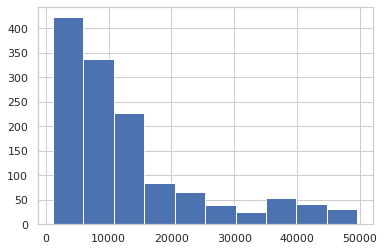

In [13]:
print(df.shape)
df.charges.hist()

Algo que analizar, según este gráfico, es entender qué está pasando con los datos arriba de los 50,000. Parece haber muy pocos datos de este lado.

In [8]:
def detect_otliers(Datos, x):
    Q3 = Datos[x].quantile(0.75)
    Q1 = Datos[x].quantile(0.25)
    IQR = Q3 - Q1
    superior = Q3 + (1.5 * IQR)
    inferior = Q1 - (1.5 * IQR)
    out_sup = Datos[Datos[x] > superior].index
    out_inf = Datos[Datos[x] < inferior].index
    outliers = []
    for i in out_sup:
        outliers.append(i)

    for j in out_inf:
        outliers.append(j)
    
    size = len(outliers)
        
    return (f'Hay {size} valores atípicos en la variable {x}, y corresponden a los índices: {outliers}')

In [9]:
print(detect_otliers(df, 'bmi'))

#'Hay 8 valores atípicos en la variable bmi, y corresponden a los índices: [115, 285, 400, 843, 856, 1043, 1084, 1310]'

Hay 9 valores atípicos en la variable bmi, y corresponden a los índices: [116, 286, 401, 543, 847, 860, 1047, 1088, 1317]


In [12]:
print(df[df.charges>50000])
df = df[df.charges<50000]

Empty DataFrame
Columns: [age, sex, bmi, children, smoker, region, charges]
Index: []


En este caso, al ser pocos datos (6 de 1338), eliminaremos estos datos atípicos. A modo didáctico producen más ruido en la predicción que se está intentando hacer en este ejercicio. 

Sin embargo es importante aclarar que **NO SE DEBEN ELIMINAR** datos atípicos sin antes conocer a alguien que conozca o sea experto en los datos para que pueda guiarnos mejor sobre ellos.

## Viendo correlaciones
Ahora entendamos nuestros datos, viendo cómo se distribuyen y correlacionan. 

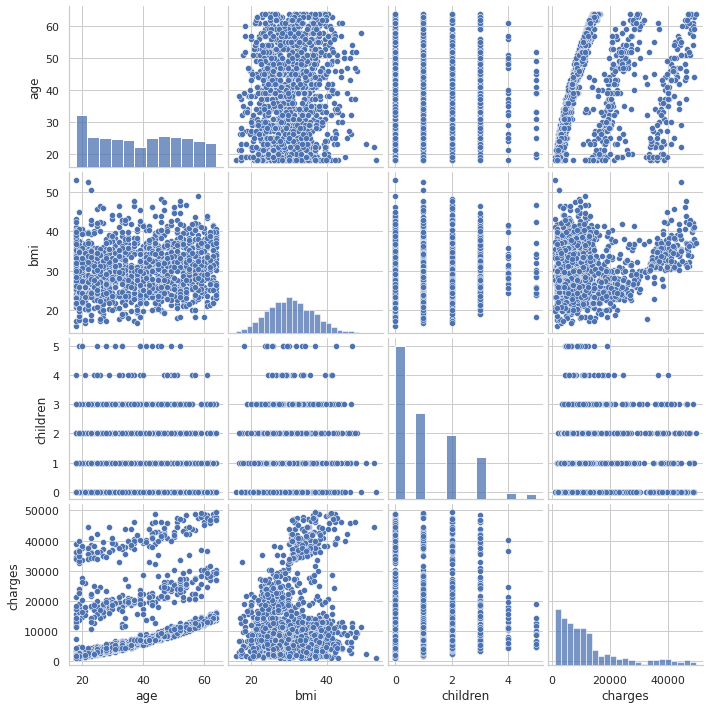

In [14]:
import matplotlib.pyplot as plt
sns.pairplot(df, height=2.5)
plt.show()

Puntos interesantes a ver:

- Hay 3 grupos de personas diferentes que se clasifican en edad / cargos, esto puede ser un punto a analizar después.

En general los valores se distribuyen de manera esperada. Con valores extremos en el caso de los cargos, sin embargo esto es de esperarse pues los cargos en los hospitales pueden variar mucho por quedarse un día más en el hospital o incluso por procedimientos extras.

- Parece que los datos están limpios, la variable de índice de masa corporal se distribuye de manera normal o gausiana, lo cual sería esperado en un índice de este tipo.

<AxesSubplot:>

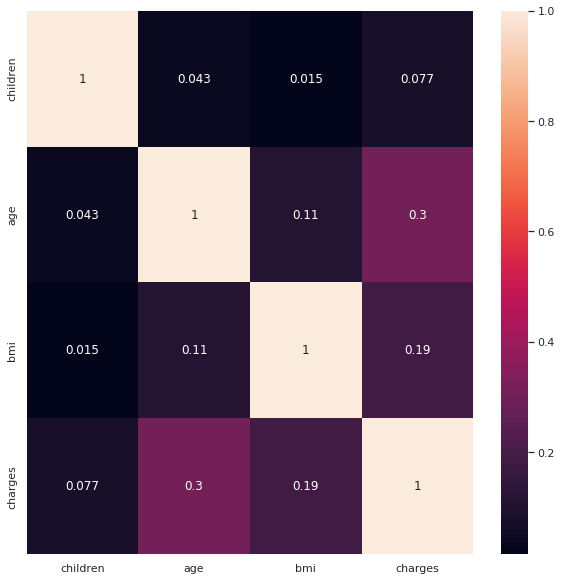

In [17]:
import numpy as np

numeric_cols = ['children', 'age', 'bmi', 'charges']
#numeric_cols = df.columns

cm_numpy = np.corrcoef(df[numeric_cols].values.T)
cm_pandas = df[numeric_cols].corr()
sns.set(rc={"figure.figsize":(10,10)})
sns.heatmap(cm_pandas, annot=True, yticklabels=numeric_cols, xticklabels=numeric_cols)

## Utilizando las demás variables
Las demás variables son variables categoricas, sexo, fumador, región. Para poder utilizarlas utilizaremos la función get_dummies de pandas. 

Ahora la verás en acción

In [43]:
df = pd.get_dummies(df, columns=['sex', 'smoker', 'region'], drop_first=True)
df.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0,1,0,0,1
1,18,33.770,1,1725.55230,1,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,1,0
3,33,22.705,0,21984.47061,1,0,1,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0


## Creando modelos 
Primero se usará un modelo con todas las variables.

In [44]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [48]:
x_cols = list(set(df.columns)-set(['charges']))
y_cols = ['charges']

x = df[x_cols].values
y = df[y_cols].values

x = StandardScaler().fit_transform(x)
y = StandardScaler().fit_transform(y)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

In [49]:
y_pred.shape

(268, 1)

## Funciones de métricas
El siguiente punto es calcular las métricas del modelo.

In [50]:
import sklearn.metrics as metrics

mse = metrics.mean_squared_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)

print(mse.round(4), r2.round(4))

0.2293 0.7836


El siguiente código muestra un resumen general de los resultados.

In [51]:
from regressors import stats

print(model.intercept_)
print(model.coef_)
model.intercept_ = model.intercept_[0]
model.coef_ = model.coef_.reshape(-1)

[0.00362759]
[[ 1.69748264e-01 -2.86870257e-02 -7.67861590e-04  2.98141630e-01
   7.88423686e-01  4.23344352e-02 -1.31311910e-02 -2.41840026e-02]]


In [52]:
print(model.intercept_)
print(model.coef_)

0.00362758508351809
[ 1.69748264e-01 -2.86870257e-02 -7.67861590e-04  2.98141630e-01
  7.88423686e-01  4.23344352e-02 -1.31311910e-02 -2.41840026e-02]


In [53]:
print(y_test.shape)
y_test = y_test.reshape(-1)
print(y_test.shape)

(268, 1)
(268,)


In [54]:
print("=====Sumary=====")
stats.summary(model, x_test, y_test, x_cols)

=====Sumary=====
Residuals:
    Min      1Q  Median    3Q    Max
-1.8876 -0.1289  0.1027 0.243 0.8684


Coefficients:
                  Estimate  Std. Error  t value   p value
_intercept        0.003628    0.029469   0.1231  0.902121
bmi               0.169748    0.030348   5.5933  0.000000
region_southwest -0.028687    0.035772  -0.8019  0.423303
sex_male         -0.000768    0.029914  -0.0257  0.979540
age               0.298142    0.029812  10.0009  0.000000
smoker_yes        0.788424    0.029822  26.4379  0.000000
children          0.042334    0.030686   1.3796  0.168870
region_northwest -0.013131    0.034524  -0.3803  0.703991
region_southeast -0.024184    0.035532  -0.6806  0.496698
---
R-squared:  0.78359,    Adjusted R-squared:  0.77691
F-statistic: 117.23 on 8 features


Finalmente tenemos la función que calcula los residuales. Es importante notar que es una simple resta entre los valores reales y los predichos.

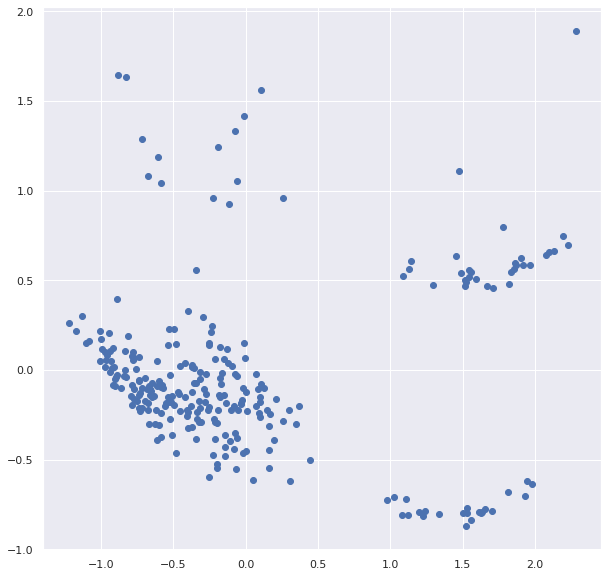

In [55]:
residuals = np.subtract(y_test, y_pred.reshape(-1))

plt.scatter(y_pred, residuals)
plt.show()

## Segundo modelo
Estos resultados de arriba son buenos, pero se pueden mejorar. Intentaremos hacer algunas transformaciones sobre las variables que pueden ser de utilidad.

In [56]:
df_second = df.copy()
df_second['age_square'] = df_second.age**2
df_second['sobrepeso'] = (df_second.bmi >= 30).astype(int)
df_second['sobrepeso_fumador'] = (df_second.sobrepeso * df_second.smoker_yes)

Analizando el segundo modelo

In [59]:
x_cols = list(set(df_second.columns)-set(['charges']))
y_cols = ['charges']

x = df_second[x_cols].values
y = df_second[y_cols].values

x = StandardScaler().fit_transform(x)
y = StandardScaler().fit_transform(y)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

In [60]:
mse = metrics.mean_squared_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)

print(mse.round(4), r2.round(4))

0.13 0.8773


In [61]:
model.intercept_ = model.intercept_[0]
model.coef_ = model.coef_.reshape(-1)

In [62]:
y_test = y_test.reshape(-1)

print("=====Sumary=====")
stats.summary(model, x_test, y_test, x_cols)

=====Sumary=====
Residuals:
    Min     1Q  Median     3Q    Max
-1.7314 0.0648  0.1103 0.1415 1.4501


Coefficients:
                   Estimate  Std. Error  t value   p value
_intercept         0.003374    0.022196   0.1520  0.879284
bmi                0.049191    0.033106   1.4859  0.138499
region_southwest  -0.047201    0.027034  -1.7460  0.081966
sex_male          -0.020968    0.022613  -0.9273  0.354633
age_square         0.309850    0.118930   2.6053  0.009694
age               -0.002601    0.120022  -0.0217  0.982728
smoker_yes         0.439042    0.030653  14.3229  0.000000
sobrepeso         -0.031644    0.033859  -0.9346  0.350851
children           0.060896    0.023402   2.6022  0.009781
region_northwest  -0.011467    0.026018  -0.4407  0.659755
sobrepeso_fumador  0.515665    0.031282  16.4846  0.000000
region_southeast  -0.026106    0.026897  -0.9706  0.332626
---
R-squared:  0.87731,    Adjusted R-squared:  0.87204
F-statistic: 166.41 on 11 features


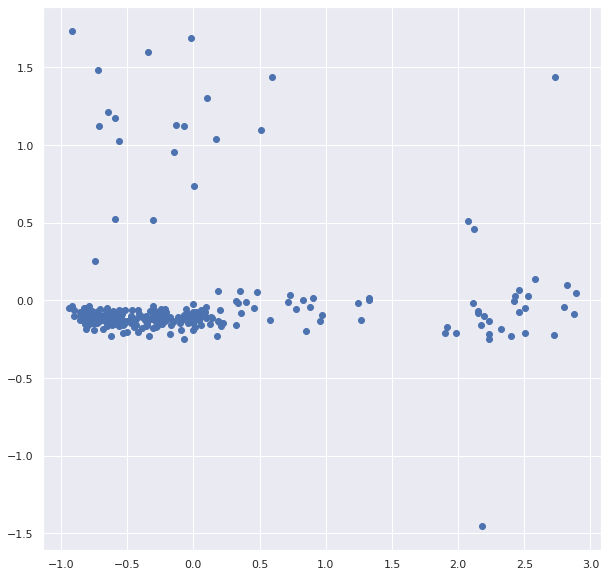

In [63]:
residuals = np.subtract(y_test, y_pred.reshape(-1))

plt.scatter(y_pred, residuals)
plt.show()

Modelo solo con parámetros con p valor menor a 0.05

In [64]:
x_cols = ['age_square', 'smoker_yes', 'sobrepeso_fumador', 'children']
y_cols = ['charges']

x = df_second[x_cols].values
y = df_second[y_cols].values

x = StandardScaler().fit_transform(x)
y = StandardScaler().fit_transform(y)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

model = LinearRegression(fit_intercept=False)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

In [67]:
mse = metrics.mean_squared_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)

print(mse.round(4), r2.round(4))

0.1328 0.8746


In [69]:
#model.intercept_ = model.intercept_[0]
model.coef_ = model.coef_.reshape(-1)

In [70]:
y_test = y_test.reshape(-1)

print("=====Sumary=====")
stats.summary(model, x_test, y_test, x_cols)

=====Sumary=====
Residuals:
    Min     1Q  Median     3Q    Max
-1.7589 0.0706  0.1119 0.1277 1.5601


Coefficients:
                   Estimate  Std. Error  t value   p value
_intercept         0.000000    0.022302   0.0000  1.000000
age_square         0.309578    0.022436  13.7985  0.000000
smoker_yes         0.439283    0.029386  14.9488  0.000000
sobrepeso_fumador  0.513923    0.028632  17.9491  0.000000
children           0.060307    0.023165   2.6033  0.009748
---
R-squared:  0.87461,    Adjusted R-squared:  0.87270
F-statistic: 458.60 on 4 features


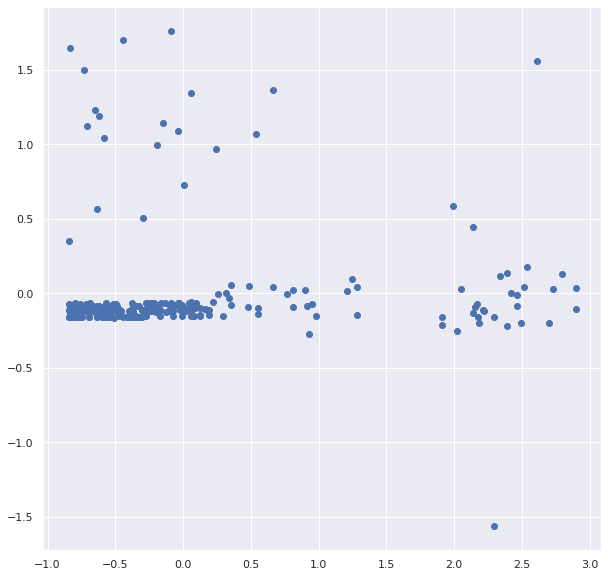

In [71]:
residuals = np.subtract(y_test, y_pred.reshape(-1))

plt.scatter(y_pred, residuals)
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=fff53006-0184-4848-b826-e5ff712e4edb' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>